In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
from types import SimpleNamespace

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [28]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

PRICE_PATH = DATA_PROCESSED / "daily_merged.parquet"
NEWS_PATH  = DATA_PROCESSED / "news_daily_features.parquet"

PRICE_PATH, NEWS_PATH


(WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/processed/daily_merged.parquet'),
 WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/processed/news_daily_features.parquet'))

In [29]:
df_price = pd.read_parquet(PRICE_PATH)
df_price["date"] = pd.to_datetime(df_price["date"])

print("=== PRICE DATA PREVIEW ===")
display(df_price.head())
print("Shape:", df_price.shape)
print("Date range:", df_price["date"].min(), "→", df_price["date"].max())
print("Label distribution:")
print(df_price["label_up"].value_counts(normalize=True))


=== PRICE DATA PREVIEW ===


,date,Close,High,Low,Open,Volume,ret_1d,log_ret_1d,ma_close_5,ma_close_20,vol_5,vol_20,future_price,future_ret_1d,label_up
0,2010-02-02,83.059364,83.217386,81.930636,82.216584,216327900,0.012104,0.012031,82.055548,84.347997,0.012653,0.010585,82.645493,-0.004983,0
1,2010-02-03,82.645493,83.134609,82.404697,82.683113,172730700,-0.004983,-0.004995,82.055548,84.205024,0.012873,0.010574,80.094604,-0.030865,0
2,2010-02-04,80.094604,82.043540,80.079552,82.005919,356715700,-0.030865,-0.031352,81.734995,83.931498,0.018783,0.012403,80.260124,0.002067,1
3,2010-02-05,80.260124,80.425666,78.694953,80.184871,493585800,0.002067,0.002064,81.625131,83.648186,0.018457,0.012344,79.680710,-0.007219,0
4,2010-02-08,79.680710,80.764291,79.620510,80.320322,224166900,-0.007219,-0.007245,81.148059,83.321606,0.015917,0.012270,80.681526,0.012560,1


Shape: (3753, 15)
Date range: 2010-02-02 00:00:00 → 2024-12-30 00:00:00
Label distribution:
label_up
1    0.552625
0    0.447375
Name: proportion, dtype: float64


In [30]:
df_news = pd.read_parquet(NEWS_PATH)
df_news["date"] = pd.to_datetime(df_news["date"])

print("=== NEWS DAILY FEATURES PREVIEW ===")
display(df_news.head())
print("Shape:", df_news.shape)
print("Date range:", df_news["date"].min(), "→", df_news["date"].max())


=== NEWS DAILY FEATURES PREVIEW ===


,date,news_sent_mean,news_sent_std,news_n_headlines,news_frac_pos,news_frac_neg
0,2010-01-05,0.127267,0.220432,3,0.333333,0.0
1,2010-01-06,-0.542300,0.000000,1,0.000000,1.0
2,2010-01-07,0.000000,0.000000,1,0.000000,0.0
3,2010-01-11,-0.177900,0.000000,1,0.000000,1.0
4,2010-01-13,-0.200950,0.284186,2,0.000000,0.5


Shape: (3311, 6)
Date range: 2010-01-05 00:00:00 → 2024-03-04 00:00:00


In [31]:
START_DATE = pd.to_datetime("2010-01-01")   # or "2018-01-01" if you want tighter
END_DATE   = pd.to_datetime("2024-12-31")

df_price_cut = df_price[(df_price["date"] >= START_DATE) & (df_price["date"] <= END_DATE)].copy()
df_news_cut  = df_news[(df_news["date"] >= START_DATE) & (df_news["date"] <= END_DATE)].copy()

df = (
    df_price_cut
    .merge(df_news_cut, on="date", how="inner")
    .sort_values("date")
    .reset_index(drop=True)
)

print("=== MERGED PRICE + NEWS PREVIEW ===")
display(df.head())
print("Shape:", df.shape)
print("Date range:", df["date"].min(), "→", df["date"].max())
print("Label distribution:")
print(df["label_up"].value_counts(normalize=True))
print("\nColumns:")
print(df.columns.tolist())


=== MERGED PRICE + NEWS PREVIEW ===


,date,Close,High,Low,Open,Volume,ret_1d,log_ret_1d,ma_close_5,ma_close_20,vol_5,vol_20,future_price,future_ret_1d,label_up,news_sent_mean,news_sent_std,news_n_headlines,news_frac_pos,news_frac_neg
0,2010-02-02,83.059364,83.217386,81.930636,82.216584,216327900,0.012104,0.012031,82.055548,84.347997,0.012653,0.010585,82.645493,-0.004983,0,0.0000,0.00000,1,0.0,0.0
1,2010-02-04,80.094604,82.043540,80.079552,82.005919,356715700,-0.030865,-0.031352,81.734995,83.931498,0.018783,0.012403,80.260124,0.002067,1,0.0000,0.00000,1,0.0,0.0
2,2010-02-05,80.260124,80.425666,78.694953,80.184871,493585800,0.002067,0.002064,81.625131,83.648186,0.018457,0.012344,79.680710,-0.007219,0,0.5160,0.00000,1,1.0,0.0
3,2010-02-08,79.680710,80.764291,79.620510,80.320322,224166900,-0.007219,-0.007245,81.148059,83.321606,0.015917,0.012270,80.681526,0.012560,1,0.3715,0.52538,2,0.5,0.0
4,2010-02-12,81.298500,81.343647,80.147199,80.508388,304622100,-0.000833,-0.000833,80.710101,82.285435,0.008516,0.012735,82.577789,0.015736,1,0.0000,0.00000,1,0.0,0.0


Shape: (3303, 20)
Date range: 2010-02-02 00:00:00 → 2024-03-04 00:00:00
Label distribution:
label_up
1    0.548895
0    0.451105
Name: proportion, dtype: float64

Columns:
['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20', 'future_price', 'future_ret_1d', 'label_up', 'news_sent_mean', 'news_sent_std', 'news_n_headlines', 'news_frac_pos', 'news_frac_neg']


In [32]:
print("NaNs per column before drop:")
print(df.isna().sum())

df = df.dropna().reset_index(drop=True)

print("\nAfter dropna:")
print("Shape:", df.shape)
print("Label distribution:")
print(df["label_up"].value_counts(normalize=True))


NaNs per column before drop:
date                0
Close               0
High                0
Low                 0
Open                0
Volume              0
ret_1d              0
log_ret_1d          0
ma_close_5          0
ma_close_20         0
vol_5               0
vol_20              0
future_price        0
future_ret_1d       0
label_up            0
news_sent_mean      0
news_sent_std       0
news_n_headlines    0
news_frac_pos       0
news_frac_neg       0
dtype: int64

After dropna:
Shape: (3303, 20)
Label distribution:
label_up
1    0.548895
0    0.451105
Name: proportion, dtype: float64


In [33]:
TRAIN_END = "2018-12-31"
VAL_END   = "2021-12-31"

def make_time_splits(df, train_end, val_end):
    dates = pd.to_datetime(df["date"])
    train_idx = np.where(dates <= pd.to_datetime(train_end))[0]
    val_idx   = np.where((dates > pd.to_datetime(train_end)) & (dates <= pd.to_datetime(val_end)))[0]
    test_idx  = np.where(dates > pd.to_datetime(val_end))[0]
    return SimpleNamespace(train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)

splits = make_time_splits(df, TRAIN_END, VAL_END)

print("Split sizes:")
print("Train:", len(splits.train_idx))
print("Val:",   len(splits.val_idx))
print("Test:",  len(splits.test_idx))

print("\nTrain date range:", df.loc[splits.train_idx, "date"].min(), "→", df.loc[splits.train_idx, "date"].max())
print("Val   date range:",   df.loc[splits.val_idx,   "date"].min(), "→", df.loc[splits.val_idx,   "date"].max())
print("Test  date range:",   df.loc[splits.test_idx,  "date"].min(), "→", df.loc[splits.test_idx,  "date"].max())


Split sizes:
Train: 2018
Val: 747
Test: 538

Train date range: 2010-02-02 00:00:00 → 2018-12-31 00:00:00
Val   date range: 2019-01-02 00:00:00 → 2021-12-31 00:00:00
Test  date range: 2022-01-03 00:00:00 → 2024-03-04 00:00:00


In [34]:
for name, idx in [("train", splits.train_idx), ("val", splits.val_idx), ("test", splits.test_idx)]:
    p_up = df.loc[idx, "label_up"].mean()
    print(f"{name} label_up mean: {p_up:.4f}  (up={p_up:.2%}, down={1-p_up:.2%})")


train label_up mean: 0.5496  (up=54.96%, down=45.04%)
val label_up mean: 0.5810  (up=58.10%, down=41.90%)
test label_up mean: 0.5019  (up=50.19%, down=49.81%)


In [35]:
# price features (same as before)
price_features = [
    "Close", "High", "Low", "Open", "Volume",
    "ret_1d", "log_ret_1d",
    "ma_close_5", "ma_close_20",
    "vol_5", "vol_20",
]

# news features from your daily aggregation
news_features = [
    "news_sent_mean",
    "news_sent_std",
    "news_n_headlines",
    "news_frac_pos",
    "news_frac_neg",
]

for f in price_features + news_features:
    if f not in df.columns:
        print("WARNING: missing feature:", f)

price_plus_news_features = price_features + news_features

print("Price-only features:", price_features)
print("Price+news features:", price_plus_news_features)


Price-only features: ['Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20']
Price+news features: ['Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20', 'news_sent_mean', 'news_sent_std', 'news_n_headlines', 'news_frac_pos', 'news_frac_neg']


In [36]:
y_all = df["label_up"].values.astype("float32")

X_price = df[price_features].values.astype("float32")
X_price_news = df[price_plus_news_features].values.astype("float32")

train_idx, val_idx, test_idx = splits.train_idx, splits.val_idx, splits.test_idx

def split_arrays(X):
    return X[train_idx], X[val_idx], X[test_idx]

Xtr_price, Xval_price, Xte_price = split_arrays(X_price)
Xtr_price_news, Xval_price_news, Xte_price_news = split_arrays(X_price_news)

y_train, y_val, y_test = y_all[train_idx], y_all[val_idx], y_all[test_idx]

print("Shapes (price-only):", Xtr_price.shape, Xval_price.shape, Xte_price.shape)
print("Shapes (price+news):", Xtr_price_news.shape, Xval_price_news.shape, Xte_price_news.shape)


Shapes (price-only): (2018, 11) (747, 11) (538, 11)
Shapes (price+news): (2018, 16) (747, 16) (538, 16)


In [37]:
p_up_train = float(y_train.mean())
p_down_train = 1.0 - p_up_train

print(f"Train label_up mean: {p_up_train:.4f}  (up={p_up_train:.2%}, down={p_down_train:.2%})")

# For BCEWithLogitsLoss, pos_weight ~ N_neg / N_pos
pos_weight_value = p_down_train / p_up_train
pos_weight_tensor = torch.tensor(pos_weight_value, device=device, dtype=torch.float32)

print("pos_weight_value:", pos_weight_value)

Train label_up mean: 0.5496  (up=54.96%, down=45.04%)
pos_weight_value: 0.8196574268117109


In [38]:
scaler_price = StandardScaler().fit(Xtr_price)
Xtr_price_scaled = scaler_price.transform(Xtr_price)
Xval_price_scaled = scaler_price.transform(Xval_price)
Xte_price_scaled  = scaler_price.transform(Xte_price)

scaler_price_news = StandardScaler().fit(Xtr_price_news)
Xtr_price_news_scaled = scaler_price_news.transform(Xtr_price_news)
Xval_price_news_scaled = scaler_price_news.transform(Xval_price_news)
Xte_price_news_scaled  = scaler_price_news.transform(Xte_price_news)


In [39]:
class SeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.from_numpy(X_seq).float()
        self.y = torch.from_numpy(y_seq).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def build_windows(X, y, window_size):
    """
    X: (T, F), y: (T,)
    Returns:
      X_seq: (N, W, F)
      y_seq: (N,), label at t+W (next day after window)
    """
    X_seq = []
    y_seq = []
    T = len(X)
    for t in range(T - window_size):
        X_seq.append(X[t:t+window_size])
        y_seq.append(y[t+window_size])
    return np.stack(X_seq), np.array(y_seq, dtype="float32")


In [40]:
class MLPWindow(nn.Module):
    def __init__(self, input_dim, hidden_sizes=(64, 32)):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, W, F)
        b, w, f = x.shape
        x = x.view(b, w * f)
        logits = self.net(x).squeeze(-1)
        return logits


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, W, F)
        out, h_n = self.gru(x)
        last_hidden = h_n[-1]   # (B, hidden_dim)
        logits = self.fc(last_hidden).squeeze(-1)
        return logits


In [41]:
def train_seq_model(
    model,
    Xtr, ytr,
    Xval, yval,
    Xte, yte,
    window_size=30,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    verbose=False,
):
    # Build windows
    Xtr_seq, ytr_seq = build_windows(Xtr, ytr, window_size)
    Xval_seq, yval_seq = build_windows(Xval, yval, window_size)
    Xte_seq, yte_seq = build_windows(Xte, yte, window_size)

    print(f"Train windows: {Xtr_seq.shape[0]} Val: {Xval_seq.shape[0]} Test: {Xte_seq.shape[0]}")

    train_ds = SeqDataset(Xtr_seq, ytr_seq)
    val_ds   = SeqDataset(Xval_seq, yval_seq)
    test_ds  = SeqDataset(Xte_seq, yte_seq)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        # train
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_examples = 0

        for Xb, yb in train_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            optim.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optim.step()

            total_loss += loss.item() * yb.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            total_correct += (preds == yb).float().sum().item()
            total_examples += yb.size(0)

        train_loss = total_loss / total_examples
        train_acc = total_correct / total_examples

        # val
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_examples = 0

        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.to(device)
                yb = yb.to(device)
                logits = model(Xb)
                loss = criterion(logits, yb)
                preds = (torch.sigmoid(logits) >= 0.5).float()
                val_loss += loss.item() * yb.size(0)
                val_correct += (preds == yb).float().sum().item()
                val_examples += yb.size(0)

        val_loss /= val_examples
        val_acc = val_correct / val_examples

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        if verbose:
            print(
                f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.4f} "
                f"| val_loss={val_loss:.4f} acc={val_acc:.4f}"
            )

    if best_state is not None:
        model.load_state_dict(best_state)

    # test
    model.eval()
    test_correct = 0
    test_examples = 0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            logits = model(Xb)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            test_correct += (preds == yb).float().sum().item()
            test_examples += yb.size(0)

            all_true.append(yb.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    test_acc = test_correct / test_examples
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)

    print(f"Best val_acc={best_val_acc:.4f} | test_acc={test_acc:.4f}")
    print("Test mean(true):", all_true.mean())
    print("Test mean(pred):", all_pred.mean())

    return best_val_acc, test_acc


In [42]:
W = 30
results = []

print("================ PRICE-ONLY vs PRICE+NEWS (W=30) ================")

# 1) MLP price-only
mlp_price = MLPWindow(input_dim=W * Xtr_price_scaled.shape[1], hidden_sizes=(64, 32))
print("\n=== MLP price-only ===")
val_acc_po_mlp, test_acc_po_mlp = train_seq_model(
    mlp_price,
    Xtr_price_scaled, y_train,
    Xval_price_scaled, y_val,
    Xte_price_scaled, y_test,
    window_size=W,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    verbose=False,
)
results.append({
    "model": "MLP",
    "features": "price_only",
    "window_size": W,
    "val_acc": val_acc_po_mlp,
    "test_acc": test_acc_po_mlp,
})

# 2) MLP price+news
mlp_price_news = MLPWindow(input_dim=W * Xtr_price_news_scaled.shape[1], hidden_sizes=(64, 32))
print("\n=== MLP price+news ===")
val_acc_pn_mlp, test_acc_pn_mlp = train_seq_model(
    mlp_price_news,
    Xtr_price_news_scaled, y_train,
    Xval_price_news_scaled, y_val,
    Xte_price_news_scaled, y_test,
    window_size=W,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    verbose=False,
)
results.append({
    "model": "MLP",
    "features": "price+news",
    "window_size": W,
    "val_acc": val_acc_pn_mlp,
    "test_acc": test_acc_pn_mlp,
})

# 3) GRU price-only
gru_price = GRUNet(input_dim=Xtr_price_scaled.shape[1], hidden_dim=32, num_layers=1)
print("\n=== GRU price-only ===")
val_acc_po_gru, test_acc_po_gru = train_seq_model(
    gru_price,
    Xtr_price_scaled, y_train,
    Xval_price_scaled, y_val,
    Xte_price_scaled, y_test,
    window_size=W,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    verbose=False,
)
results.append({
    "model": "GRU",
    "features": "price_only",
    "window_size": W,
    "val_acc": val_acc_po_gru,
    "test_acc": test_acc_po_gru,
})

# 4) GRU price+news
gru_price_news = GRUNet(input_dim=Xtr_price_news_scaled.shape[1], hidden_dim=32, num_layers=1)
print("\n=== GRU price+news ===")
val_acc_pn_gru, test_acc_pn_gru = train_seq_model(
    gru_price_news,
    Xtr_price_news_scaled, y_train,
    Xval_price_news_scaled, y_val,
    Xte_price_news_scaled, y_test,
    window_size=W,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    verbose=False,
)
results.append({
    "model": "GRU",
    "features": "price+news",
    "window_size": W,
    "val_acc": val_acc_pn_gru,
    "test_acc": test_acc_pn_gru,
})

results_df = pd.DataFrame(results)
results_df


================ PRICE-ONLY vs PRICE+NEWS (W=30) ================

=== MLP price-only ===
Train windows: 1988 Val: 717 Test: 508
Best val_acc=0.5662 | test_acc=0.4882
Test mean(true): 0.507874
Test mean(pred): 0.031496063

=== MLP price+news ===
Train windows: 1988 Val: 717 Test: 508
Best val_acc=0.5732 | test_acc=0.5177
Test mean(true): 0.507874
Test mean(pred): 0.6082677

=== GRU price-only ===
Train windows: 1988 Val: 717 Test: 508
Best val_acc=0.5872 | test_acc=0.5118
Test mean(true): 0.507874
Test mean(pred): 0.996063

=== GRU price+news ===
Train windows: 1988 Val: 717 Test: 508
Best val_acc=0.5816 | test_acc=0.5059
Test mean(true): 0.507874
Test mean(pred): 0.96259844


,model,features,window_size,val_acc,test_acc
0,MLP,price_only,30,0.566248,0.488189
1,MLP,price+news,30,0.573222,0.517717
2,GRU,price_only,30,0.587169,0.511811
3,GRU,price+news,30,0.581590,0.505906


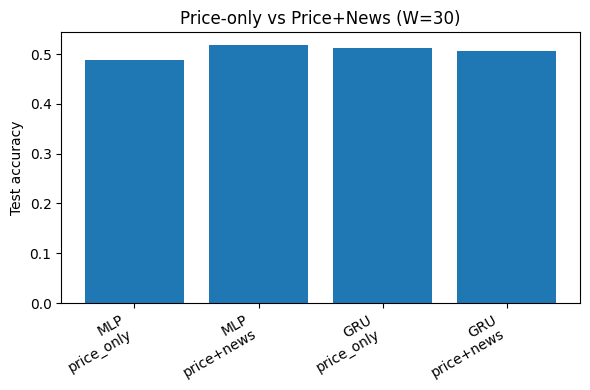

,model,features,window_size,val_acc,test_acc
0,MLP,price_only,30,0.566248,0.488189
1,MLP,price+news,30,0.573222,0.517717
2,GRU,price_only,30,0.587169,0.511811
3,GRU,price+news,30,0.581590,0.505906


In [43]:
plt.figure(figsize=(6, 4))
x_labels = [f"{m}\n{f}" for m, f in zip(results_df["model"], results_df["features"])]
plt.bar(range(len(results_df)), results_df["test_acc"].values)
plt.xticks(range(len(results_df)), x_labels, rotation=30, ha="right")
plt.ylabel("Test accuracy")
plt.title("Price-only vs Price+News (W=30)")
plt.tight_layout()
plt.show()

results_df


In [44]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.from_numpy(X_seq).float()
        self.y = torch.from_numpy(y_seq).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def build_windows(X, y, window_size):
    X_seq, y_seq = [], []
    T = len(X)
    for t in range(T - window_size):
        X_seq.append(X[t:t+window_size])
        y_seq.append(y[t+window_size])
    return np.stack(X_seq), np.array(y_seq, dtype="float32")


def train_seq_model_reg(
    model,
    Xtr, ytr,
    Xval, yval,
    Xte, yte,
    window_size=30,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    pos_weight=None,
    verbose=False,
):
    # Build windows
    Xtr_seq, ytr_seq = build_windows(Xtr, ytr, window_size)
    Xval_seq, yval_seq = build_windows(Xval, yval, window_size)
    Xte_seq, yte_seq = build_windows(Xte, yte, window_size)

    print(f"Train windows: {Xtr_seq.shape[0]} Val: {Xval_seq.shape[0]} Test: {Xte_seq.shape[0]}")

    train_ds = SeqDataset(Xtr_seq, ytr_seq)
    val_ds   = SeqDataset(Xval_seq, yval_seq)
    test_ds  = SeqDataset(Xte_seq, yte_seq)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = model.to(device)

    if pos_weight is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,   # <-- L2 regularization
    )

    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        # ----- Train -----
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_examples = 0

        for Xb, yb in train_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * yb.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            total_correct += (preds == yb).float().sum().item()
            total_examples += yb.size(0)

        train_loss = total_loss / total_examples
        train_acc = total_correct / total_examples

        # ----- Val -----
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_examples = 0

        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.to(device)
                yb = yb.to(device)

                logits = model(Xb)
                loss = criterion(logits, yb)

                preds = (torch.sigmoid(logits) >= 0.5).float()
                val_loss += loss.item() * yb.size(0)
                val_correct += (preds == yb).float().sum().item()
                val_examples += yb.size(0)

        val_loss /= val_examples
        val_acc = val_correct / val_examples

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        if verbose:
            print(
                f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.4f} "
                f"| val_loss={val_loss:.4f} acc={val_acc:.4f}"
            )

    if best_state is not None:
        model.load_state_dict(best_state)

    # ----- Test -----
    model.eval()
    test_correct = 0
    test_examples = 0
    all_true, all_pred = [], []

    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            logits = model(Xb)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            test_correct += (preds == yb).float().sum().item()
            test_examples += yb.size(0)

            all_true.append(yb.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    test_acc = test_correct / test_examples
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)

    print(f"[REG] Best val_acc={best_val_acc:.4f} | test_acc={test_acc:.4f}")
    print("Test mean(true):", all_true.mean())
    print("Test mean(pred):", all_pred.mean())

    return best_val_acc, test_acc


In [45]:
input_dim_price = Xtr_price_scaled.shape[1]
W = 30

results_reg = []

print("========== ADVANCED: GRU price-only with regularization ==========")

# 1) Baseline (no reg, no class weight) – for comparison
gru_base = GRUNet(input_dim=input_dim_price, hidden_dim=32, num_layers=1)
print("\nGRU price-only (baseline, no reg):")
val_acc_base, test_acc_base = train_seq_model_reg(
    gru_base,
    Xtr_price_scaled, y_train,
    Xval_price_scaled, y_val,
    Xte_price_scaled, y_test,
    window_size=W,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    pos_weight=None,
    verbose=False,
)
results_reg.append({
    "config": "GRU price-only baseline",
    "val_acc": val_acc_base,
    "test_acc": test_acc_base,
})

# 2) L2 weight decay only
gru_l2 = GRUNet(input_dim=input_dim_price, hidden_dim=32, num_layers=1)
print("\nGRU price-only (weight_decay=1e-4):")
val_acc_l2, test_acc_l2 = train_seq_model_reg(
    gru_l2,
    Xtr_price_scaled, y_train,
    Xval_price_scaled, y_val,
    Xte_price_scaled, y_test,
    window_size=W,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=1e-4,
    pos_weight=None,
    verbose=False,
)
results_reg.append({
    "config": "GRU price-only + L2(1e-4)",
    "val_acc": val_acc_l2,
    "test_acc": test_acc_l2,
})

# 3) L2 + class-weighted loss
gru_l2_cw = GRUNet(input_dim=input_dim_price, hidden_dim=32, num_layers=1)
print("\nGRU price-only (weight_decay=1e-4 + pos_weight):")
val_acc_l2_cw, test_acc_l2_cw = train_seq_model_reg(
    gru_l2_cw,
    Xtr_price_scaled, y_train,
    Xval_price_scaled, y_val,
    Xte_price_scaled, y_test,
    window_size=W,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=1e-4,
    pos_weight=pos_weight_tensor,
    verbose=False,
)
results_reg.append({
    "config": "GRU price-only + L2(1e-4) + pos_weight",
    "val_acc": val_acc_l2_cw,
    "test_acc": test_acc_l2_cw,
})

pd.DataFrame(results_reg)


========== ADVANCED: GRU price-only with regularization ==========

GRU price-only (baseline, no reg):
Train windows: 1988 Val: 717 Test: 508
[REG] Best val_acc=0.5886 | test_acc=0.5138
Test mean(true): 0.507874
Test mean(pred): 0.9901575

GRU price-only (weight_decay=1e-4):
Train windows: 1988 Val: 717 Test: 508
[REG] Best val_acc=0.5774 | test_acc=0.5276
Test mean(true): 0.507874
Test mean(pred): 0.8228347

GRU price-only (weight_decay=1e-4 + pos_weight):
Train windows: 1988 Val: 717 Test: 508
[REG] Best val_acc=0.5816 | test_acc=0.4921
Test mean(true): 0.507874
Test mean(pred): 0.007874016


,config,val_acc,test_acc
0,GRU price-only baseline,0.588563,0.513780
1,GRU price-only + L2(1e-4),0.577406,0.527559
2,GRU price-only + L2(1e-4) + pos_weight,0.581590,0.492126
